# Homework week 9

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [54]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import seaborn as sns
import statsmodels.api as sm
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

The data in `data(Achehunting)` are 14,364 individual hunting trips by 147 men
among the indigenous Ache  of Paraguay. Each trip has recorded the hunter’s identity
(anonymized id), hunter’s age at the time of the trip, the duration in hours of the
trip, and the kilograms of meat returned. Many of the trips have missing values for
duration.

# Q1

In this first problem, estimate the influence of age on the probability of trip success.
Define “success” as a trip that returns any non-zero amount of meat. Ignore
individual hunter identities for now. You can use any functional relationship for age
and success that you think is sensible, but be sure to justify it and check it against
posterior predictions.

## Answer

In [9]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_ache = pd.read_csv(DATA_DIR + "Achehunting.csv", sep=";", header=0)
df_ache.head()

,month,day,year,id,age,kg.meat,hours,datatype
0,10,2.0,1981,3043,67,0.0,6.97,1.0
1,10,3.0,1981,3043,67,0.0,9.00,1.0
2,10,4.0,1981,3043,67,0.0,1.55,1.0
3,10,5.0,1981,3043,67,4.5,8.00,1.0
4,10,6.0,1981,3043,67,0.0,3.00,1.0


<IPython.core.display.Javascript object>

Do some basic data exploration to edit categories.

In [10]:
df_ache['datatype'].value_counts()

3.0    11969
1.0     2314
1.1       81
Name: datatype, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
# Make a binary 
df_ache['success'] = 0
df_ache.loc[df_ache['kg.meat'] > 0 ,'success'] = 1


<IPython.core.display.Javascript object>

In [15]:
df_ache['success'].value_counts()

0    7505
1    6859
Name: success, dtype: int64

<IPython.core.display.Javascript object>

<AxesSubplot:>

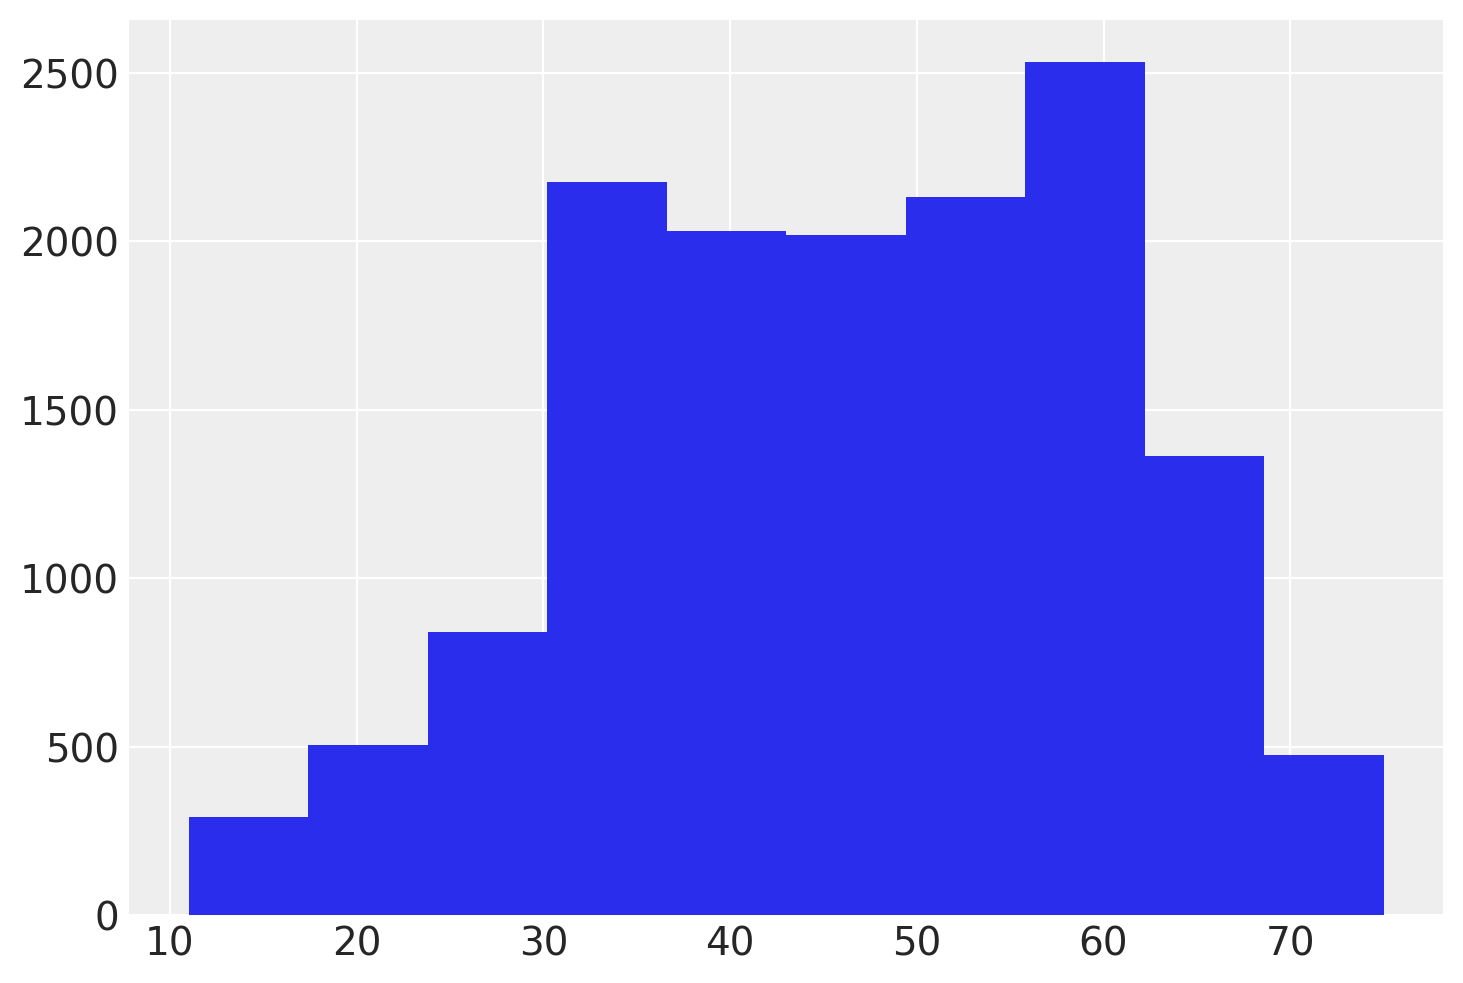

<IPython.core.display.Javascript object>

In [16]:
df_ache['age'].hist()

I'll standardize age.

In [17]:
# standardize variables
df_ache['age_std'] = standardize(df_ache['age'])
df_ache.head()

,month,day,year,id,age,kg.meat,hours,datatype,success,age_std
0,10,2.0,1981,3043,67,0.0,6.97,1.0,0,1.51767
1,10,3.0,1981,3043,67,0.0,9.00,1.0,0,1.51767
2,10,4.0,1981,3043,67,0.0,1.55,1.0,0,1.51767
3,10,5.0,1981,3043,67,4.5,8.00,1.0,1,1.51767
4,10,6.0,1981,3043,67,0.0,3.00,1.0,0,1.51767


<IPython.core.display.Javascript object>

In [23]:
df_ache.shape

(14364, 10)

<IPython.core.display.Javascript object>

Since we're explicitly asked to ignore `id`, we'll make this a simple binomial regression.

$$ S_i \sim \text{Binomial}(1, p_i) $$
$$ \text{logit}(p) = \alpha + \beta_\text{age} A$$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_\text{age} \sim \text{Normal}(0, 1) $$

Alpha is the average success?

In [22]:
# write model
with pm.Model() as mq1a:

    # Priors
    a = pm.Normal("a", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(a + bA * df_ache['age_std']))

    # likelihood
    s = pm.Binomial("s", n=1, p=p, observed=df_ache['success'])

    # prior predictive simulation
    prior_checks_mq1a = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    trace_mq1a = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

    # posterior predictive simulation
    post_checks_mq1a = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


<IPython.core.display.Javascript object>

In [27]:
az.summary(trace_mq1a, var_names=['a', 'bA'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.09,0.016,-0.118,-0.065,0.0,0.0,3479.0,3433.0,3488.0,2481.0,1.0
bA,0.06,0.017,0.034,0.089,0.0,0.0,3594.0,3471.0,3602.0,2924.0,1.0


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

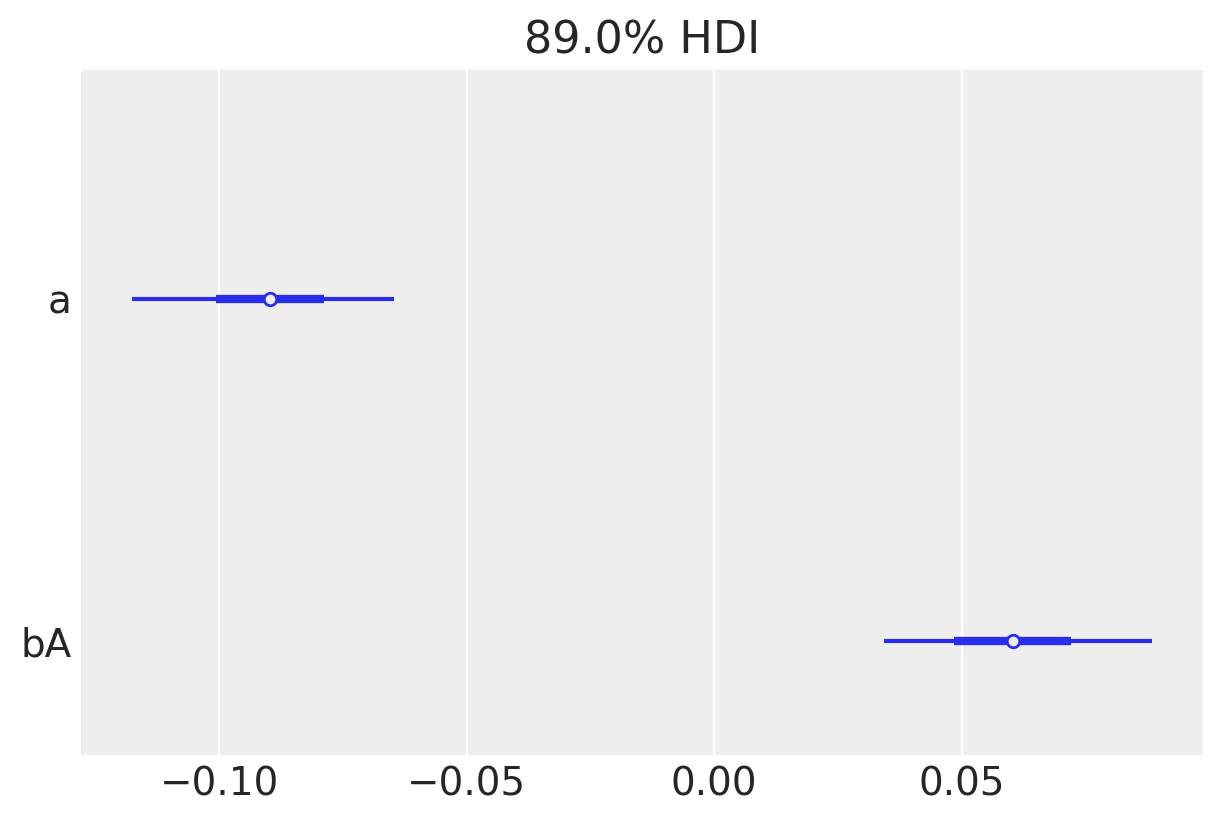

<IPython.core.display.Javascript object>

In [30]:
f, ax0 = plt.subplots(figsize=(6, 4))
az.plot_forest(trace_mq1a, var_names=['a', 'bA'], combined=True, ax=ax0)

Text(0.5, 1.0, 'Posterior predictive checks')

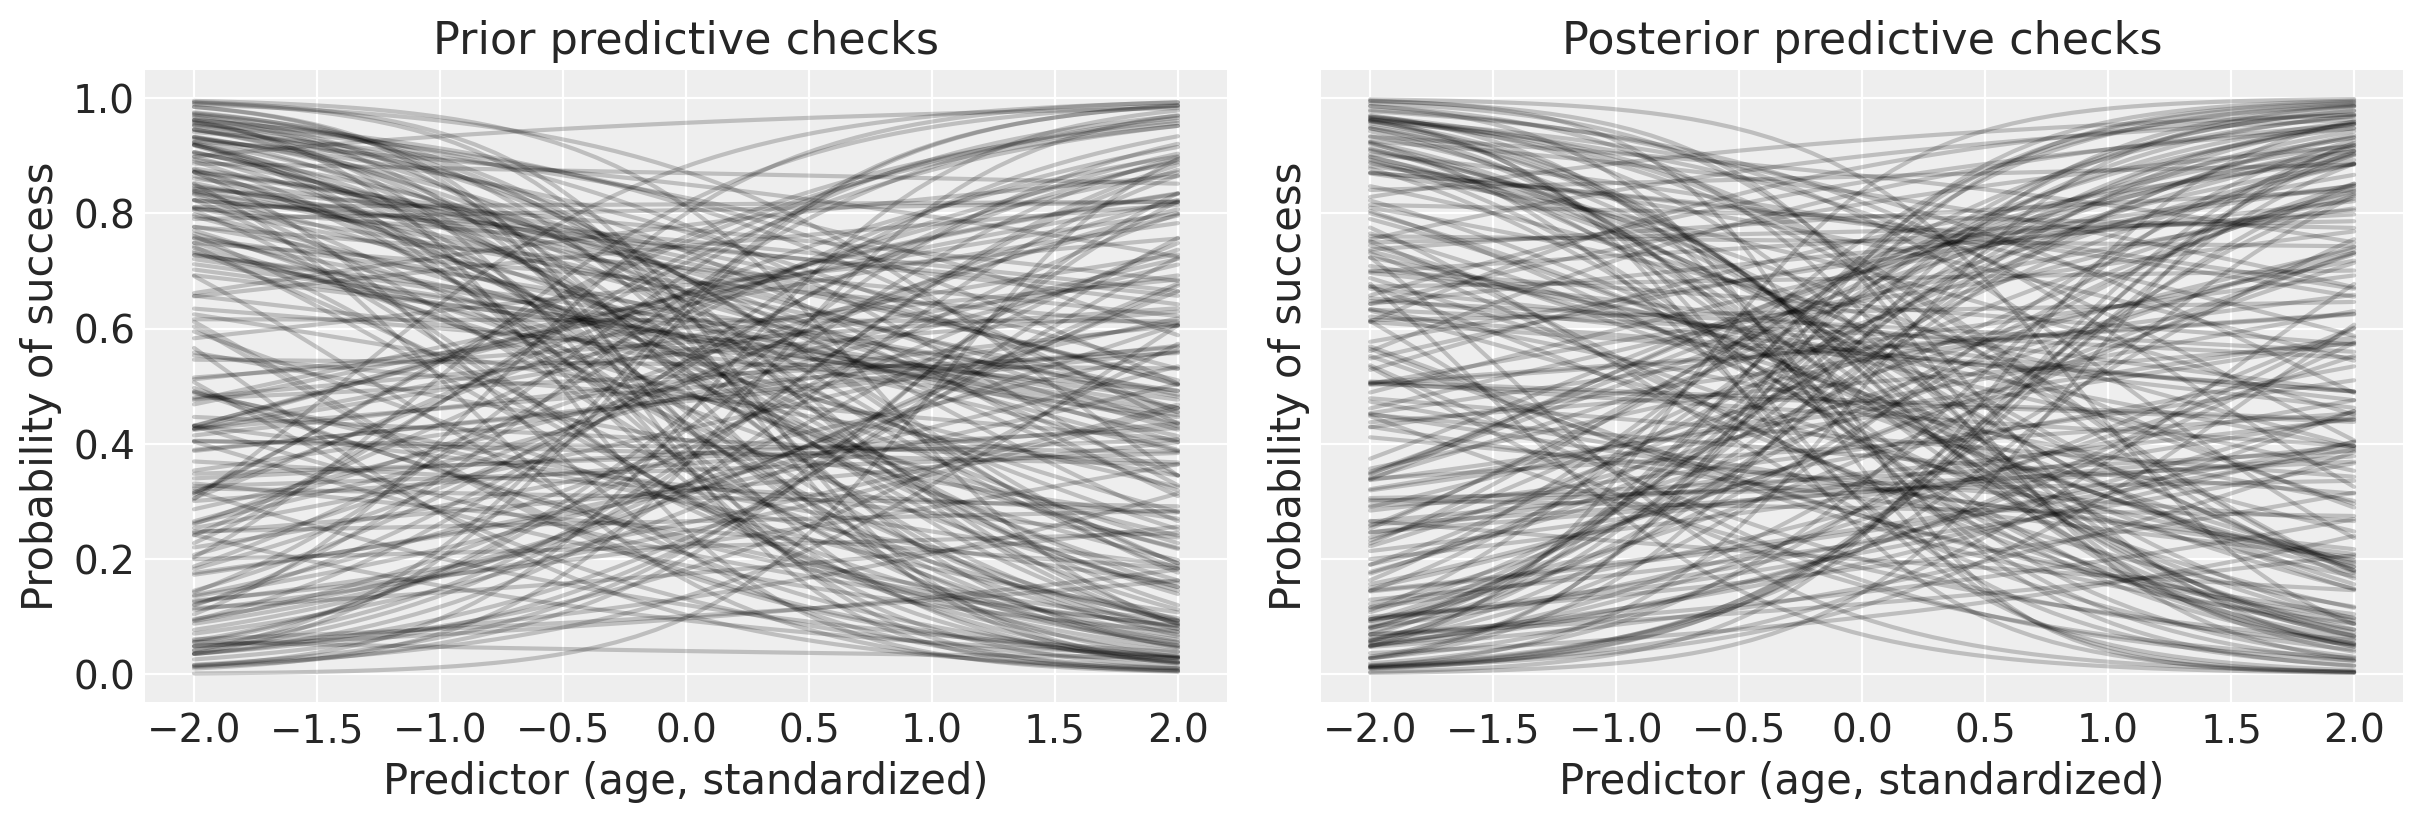

<IPython.core.display.Javascript object>

In [39]:
# prior and posterior checks
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

x = np.linspace(-2, 2, 50)

# prior predictive
for a, bA in zip(prior_checks_mq1a["a"], prior_checks_mq1a["bA"]):
    p = expit(a + bA * x)
    ax0.plot(x, p, c="k", alpha=0.2)

ax0.set_xlabel("Predictor (age, standardized)")
ax0.set_ylabel("Probability of success")
ax0.set_title("Prior predictive checks")

# posterior predictive
for a, bA in zip(post_checks_mq1a["a"], post_checks_mq1a["bA"]):
    p = expit(a + bA * x)
    ax1.plot(x, p, c="k", alpha=0.2)

ax1.set_xlabel("Predictor (age, standardized)")
ax1.set_title("Posterior predictive checks")

In [45]:
print(f"change in log-odds: {expit(0.883)}")

change in log-odds: 0.7074435088458491


<IPython.core.display.Javascript object>

**This says that increasing age by one standard deviation will change  about 0.882 standardized units of average food.**

But I'm thinking that the function shouldn't be a classic logistic shape. Rather it should rise in the middle then fall? The youngest are less likely to have a successful hunt but the oldest are less likely as well.

Just not sure how to code it.

In [46]:
# write model
with pm.Model() as mq1b:

    # Priors
    bA = pm.Normal("bA", mu=0, sd=1)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(bA * df_ache['age_std']))

    # likelihood
    s = pm.Binomial("s", n=1, p=p, observed=df_ache['success'])

    # prior predictive simulation
    prior_checks_mq1b = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    trace_mq1b = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

    # posterior predictive simulation
    post_checks_mq1b = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA]
INFO:pymc3:NUTS: [bA]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


<IPython.core.display.Javascript object>

In [89]:
# # prior and posterior checks
# f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# x = np.linspace(-2, 2, 50)

# # prior predictive
# for bA in zip(prior_checks_mq1b["bA"]):
#     p = 1 - expit(bA * x)
#     ax0.plot(x, p, c="k", alpha=0.2)

# ax0.set_xlabel("Predictor (age, standardized)")
# ax0.set_ylabel("Probability of success")
# ax0.set_title("Prior predictive checks")

# # posterior predictive
# for a, bA in zip(post_checks_mq1a["a"], post_checks_mq1a["bA"]):
#     p = expit(a + bA * x)
#     ax1.plot(x, p, c="k", alpha=0.2)

# ax1.set_xlabel("Predictor (age, standardized)")
# ax1.set_title("Posterior predictive checks")

<IPython.core.display.Javascript object>

### Age with Gaussian process regression

[Chris Fonnesbeck GPR primer video](https://www.youtube.com/watch?v=j7Ruu3Yu-70) was helpful for this section.

We want $\beta$ to change with the age data points. We'll use the flexibility and non-linearity that Gaussian processes provides.

$$ S_i \sim \text{Binomial}(1, p_i) $$
$$ \text{logit}(p) = \alpha + \beta_\text{age} A$$
$$\begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \textbf{S} \right)  \tag{population of varying effects} $$

In [ ]:
# attempt following 14.39 code and Fonnesback tutorial
with pm.Model() as mq1c:

    # Priors
    bA = pm.Normal("bA", mu=0, sd=1)

    





    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(bA * df_ache['age_std']))

    # likelihood
    s = pm.Binomial("s", n=1, p=p, observed=df_ache['success'])

    # prior predictive simulation
    prior_checks_mq1b = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    trace_mq1b = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

    # posterior predictive simulation
    post_checks_mq1c = pm.sample_prior_predictive(samples=200)

# Q2

Now incorporate individual hunter varying effects into your analysis from the
previous problem. Allow the influence of age on success to vary by each individual.
How much variation in success is explained by individuals and how much by age?

## Answer


$$ S_i \sim \text{Binomial}(1, p_i) $$
$$ \text{logit}(p) = \alpha_\text{ID} + \beta_\text{age, ID} A$$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_\text{age} \sim \text{Normal}(0, 1) $$

In [50]:
df_ache.head(10)

,month,day,year,id,age,kg.meat,hours,datatype,success,age_std
0,10,2.0,1981,3043,67,0.0,6.97,1.0,0,1.51767
1,10,3.0,1981,3043,67,0.0,9.00,1.0,0,1.51767
2,10,4.0,1981,3043,67,0.0,1.55,1.0,0,1.51767
3,10,5.0,1981,3043,67,4.5,8.00,1.0,1,1.51767
4,10,6.0,1981,3043,67,0.0,3.00,1.0,0,1.51767
5,10,7.0,1981,3043,67,0.0,7.50,1.0,0,1.51767
6,10,8.0,1981,3043,67,0.0,9.00,1.0,0,1.51767
7,2,6.0,1982,3043,68,0.0,7.30,1.0,0,1.59147
8,2,7.0,1982,3043,68,0.0,8.10,1.0,0,1.59147
9,2,8.0,1982,3043,68,0.0,6.00,1.0,0,1.59147


<IPython.core.display.Javascript object>

In [53]:
# code id for python
df_ache['id_code'] = pd.Categorical(df_ache['id']).codes
n_hunters = len(df_ache['id_code'].unique())

<IPython.core.display.Javascript object>

In [55]:
with pm.Model() as mq2a:

    """
    Centered model
    """
    
    # Standard deviation to make covariance matrix
    sigmas = pm.Exponential.dist(1.0)

    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=sigmas, compute_corr=True
    )   # n is number of parameters to estimate

    a = pm.Normal("a", mu=0, sd=1)  # prior for average intercept
    bA = pm.Normal("bA", mu=-0, sd=1)  # prior for average slope
    ab_hunter = pm.MvNormal(
        "ab_hunter", mu=tt.stack([a, bA]), chol=chol, shape=(n_hunters, 2)
    )  # population of varying effects

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_hunter[df_ache["id_code"], 0]
            + ab_hunter[df_ache["id_code"], 1] * df_ache["age_std"]
        ),
    )

    # prior predictive simulation
    prior_checks_mq2a = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    trace_mq2a = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

    # posterior predictive simulation
    post_checks_mq2a = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_cafe, bA, a, chol_cov]
INFO:pymc3:NUTS: [ab_cafe, bA, a, chol_cov]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6570950095842377, but should be close to 0.8. Try to increase the number of tuning steps.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:

<IPython.core.display.Javascript object>

In [63]:
az.summary(trace_mq2a, var_names=['ab_cafe']) 

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"ab_cafe[0,0]",-0.118,1.928,-3.082,2.731,0.235,0.167,67.0,67.0,54.0,338.0,1.05
"ab_cafe[0,1]",0.209,2.195,-3.394,3.079,0.079,0.102,772.0,234.0,486.0,557.0,1.04
"ab_cafe[1,0]",-0.142,1.846,-2.704,2.621,0.229,0.163,65.0,65.0,48.0,410.0,1.06
"ab_cafe[1,1]",0.034,2.120,-3.135,3.168,0.090,0.103,559.0,211.0,383.0,479.0,1.05
"ab_cafe[2,0]",-0.127,1.927,-2.957,3.114,0.221,0.157,76.0,76.0,77.0,73.0,1.06
...,...,...,...,...,...,...,...,...,...,...,...
"ab_cafe[144,1]",0.198,2.076,-2.963,3.507,0.098,0.092,450.0,258.0,306.0,431.0,1.04
"ab_cafe[145,0]",-0.161,1.803,-2.763,2.688,0.189,0.134,91.0,91.0,74.0,589.0,1.05
"ab_cafe[145,1]",0.031,2.117,-3.166,3.036,0.099,0.113,461.0,175.0,349.0,391.0,1.05
"ab_cafe[146,0]",-0.174,1.830,-2.893,2.495,0.134,0.095,187.0,187.0,133.0,520.0,1.03


<IPython.core.display.Javascript object>

This has poor sampling efficiency (low ESS, high r_hat).

In [92]:
with pm.Model() as mq2b:

    """
    Non-centered model
    """
    
    # Standard deviation to make covariance matrix
    sigmas = pm.Exponential.dist(1.0)

    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=sigmas, compute_corr=True
    )   # n is number of parameters to estimate

    z = pm.Normal("z", 0.0, 1.0, shape=(2, n_hunters))
    ab_hunter = pm.Deterministic("ab_hunter", pm.math.dot(chol, z).T)

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_hunter[df_ache["id_code"], 0]
            + ab_hunter[df_ache["id_code"], 1] * df_ache["age_std"]
        ),
    )

    # prior predictive simulation
    prior_checks_mq2b = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    trace_mq2b = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

    # posterior predictive simulation
    post_checks_mq2b = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, chol_cov]
INFO:pymc3:NUTS: [z, chol_cov]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


<IPython.core.display.Javascript object>

In [68]:
# df_summary_mq2b = az.summary(trace_mq2b)

<IPython.core.display.Javascript object>

In [66]:
az.summary(trace_mq2b, var_names=['ab_hunter']) 

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"ab_hunter[0,0]",0.130,1.900,-1.855,2.389,0.104,0.098,336.0,187.0,1159.0,654.0,1.00
"ab_hunter[0,1]",-0.028,1.312,-1.610,2.143,0.021,0.018,3989.0,2780.0,4728.0,2712.0,1.00
"ab_hunter[1,0]",-0.061,1.603,-1.995,2.001,0.062,0.044,661.0,661.0,1862.0,849.0,1.00
"ab_hunter[1,1]",0.017,1.368,-1.966,1.888,0.021,0.019,4290.0,2465.0,4426.0,3196.0,1.01
"ab_hunter[2,0]",0.016,1.477,-1.794,2.104,0.029,0.022,2679.0,2183.0,3077.0,2541.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"ab_hunter[144,1]",-0.019,1.374,-1.893,1.936,0.020,0.020,4568.0,2384.0,5199.0,3108.0,1.00
"ab_hunter[145,0]",-0.116,1.787,-2.245,1.903,0.087,0.080,423.0,251.0,1377.0,909.0,1.00
"ab_hunter[145,1]",0.008,1.405,-1.926,1.876,0.021,0.021,4516.0,2253.0,4404.0,2650.0,1.00
"ab_hunter[146,0]",0.026,1.419,-1.881,2.015,0.027,0.019,2680.0,2680.0,2636.0,2704.0,1.00


<IPython.core.display.Javascript object>

Sampling efficiency isn't great for all samples, but it's better in the non-centered model. To assess "how much variation in success is explained by individuals and how much by age", I'm not sure, but I'm thinking the zeroth index of `ab_hunter` is the variation by individual and the first index is age?

In [88]:
az.summary(trace_mq2b, var_names=['chol_cov_corr'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.00,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",-0.002,0.445,-0.701,0.73,0.007,0.008,3653.0,1744.0,3717.0,2599.0,1.0
"chol_cov_corr[1,0]",-0.002,0.445,-0.701,0.73,0.007,0.008,3653.0,1744.0,3717.0,2599.0,1.0
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.00,0.000,0.000,4000.0,4000.0,3979.0,3951.0,1.0


<IPython.core.display.Javascript object>

In [90]:
az.summary(trace_mq2b, var_names=['chol_cov_stds'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol_cov_stds[0],1.061,1.116,0.001,2.348,0.043,0.044,660.0,319.0,1736.0,772.0,1.00
chol_cov_stds[1],0.991,0.973,0.016,2.167,0.029,0.021,1106.0,1106.0,595.0,300.0,1.01


<IPython.core.display.Javascript object>

# Q3

Now include trip duration in the model from the previous problem. The focus
is still the causal relationship between age and success, but duration is a potential
competing cause or a mediator, so it is useful to include it. Since there are many
missing values for trip duration, compare (1) a complete case analysis, which drops
all the trips with missing durations, to (2) an analysis which uses all 14,364 trips and
imputes missing duration values where necessary. Use any functional relationship
between duration and success that you think is sensible, but be sure to justify it and
check it against posterior predictions.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


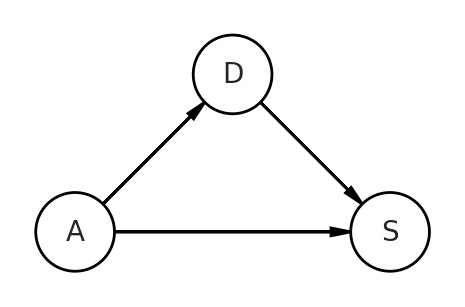

<IPython.core.display.Javascript object>

In [73]:
dag = CausalGraphicalModel(
    nodes=["A", "D", "S"],
    edges=[
        ("A", "S"),
        ("A", "D"),
        ("D", "S"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "A": (0, 0),
    "D": (1, 1),
    "S": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

I think a longer trip would be associated with a higher probability of success.

In [76]:
df_ache['hours_std'] = standardize(df_ache['hours'])
df_ache.head()

,month,day,year,id,age,kg.meat,hours,datatype,success,age_std,id_code,hours_std
0,10,2.0,1981,3043,67,0.0,6.97,1.0,0,1.51767,0,0.060793
1,10,3.0,1981,3043,67,0.0,9.00,1.0,0,1.51767,0,0.986234
2,10,4.0,1981,3043,67,0.0,1.55,1.0,0,1.51767,0,-2.410088
3,10,5.0,1981,3043,67,4.5,8.00,1.0,1,1.51767,0,0.530352
4,10,6.0,1981,3043,67,0.0,3.00,1.0,0,1.51767,0,-1.749059


<IPython.core.display.Javascript object>

In [77]:
df_ache.shape

(14364, 12)

<IPython.core.display.Javascript object>

In [81]:
df_ache_cc = df_ache[df_ache['hours'].notna()].copy()
df_ache_cc['id_code2'] = pd.Categorical(df_ache_cc['id']).codes
n_hunters_cc = len(df_ache_cc['id_code2'].unique())

<IPython.core.display.Javascript object>

In [82]:
with pm.Model() as mq3a:

    """
    Non-centered model. Assume covariance between age, age, duration.
    Direct effect of age.
    """
    
    # Standard deviation to make covariance matrix
    sigmas = pm.Exponential.dist(1.0)

    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol_cov", n=3, eta=2, sd_dist=sigmas, compute_corr=True
    )   # n is number of parameters to estimate

    z = pm.Normal("z", 0.0, 1.0, shape=(3, n_hunters_cc))
    ab_hunter = pm.Deterministic("ab_hunter", pm.math.dot(chol, z).T)

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_hunter[df_ache_cc["id_code2"], 0]
            + ab_hunter[df_ache_cc["id_code2"], 1] * df_ache_cc["age_std"]
            + ab_hunter[df_ache_cc["id_code2"], 2] * df_ache_cc["hours_std"]
        ),
    )

    # prior predictive simulation
    prior_checks_mq3a = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    trace_mq3a = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

    # posterior predictive simulation
    post_checks_mq3a = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, chol_cov]
INFO:pymc3:NUTS: [z, chol_cov]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The acceptance probability does not match the target. It is 0.9024815375220646, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8572501080290799, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [83]:
az.summary(trace_mq3a, var_names=['ab_hunter'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"ab_hunter[0,0]",-0.030,1.456,-2.139,1.726,0.028,0.021,2718.0,2295.0,3277.0,2220.0,1.00
"ab_hunter[0,1]",-0.016,1.409,-2.096,1.733,0.023,0.021,3708.0,2149.0,3792.0,2660.0,1.01
"ab_hunter[0,2]",0.031,1.366,-1.980,2.054,0.024,0.026,3361.0,1361.0,2748.0,2341.0,1.01
"ab_hunter[1,0]",-0.021,1.438,-1.833,1.922,0.028,0.021,2713.0,2343.0,3521.0,2940.0,1.00
"ab_hunter[1,1]",0.044,1.457,-1.899,1.890,0.024,0.023,3830.0,1955.0,2737.0,2516.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"ab_hunter[108,1]",-0.016,1.461,-2.523,1.473,0.035,0.025,1747.0,1747.0,1625.0,329.0,1.01
"ab_hunter[108,2]",-0.003,1.389,-2.139,1.757,0.019,0.025,5185.0,1505.0,4290.0,2240.0,1.01
"ab_hunter[109,0]",-0.017,1.421,-1.805,1.789,0.024,0.020,3413.0,2594.0,4172.0,3445.0,1.00
"ab_hunter[109,1]",-0.012,1.357,-2.001,1.802,0.021,0.020,4197.0,2224.0,4513.0,2613.0,1.01


<IPython.core.display.Javascript object>

In [87]:
az.summary(trace_mq3a, var_names=['chol_cov_corr'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",-0.002,0.408,-0.623,0.687,0.007,0.007,3536.0,1804.0,3573.0,3054.0,1.01
"chol_cov_corr[0,2]",-0.013,0.401,-0.659,0.624,0.008,0.007,2333.0,1828.0,2652.0,3008.0,1.00
"chol_cov_corr[1,0]",-0.002,0.408,-0.623,0.687,0.007,0.007,3536.0,1804.0,3573.0,3054.0,1.01
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3340.0,3855.0,1.00
"chol_cov_corr[1,2]",0.002,0.404,-0.656,0.650,0.007,0.008,3580.0,1407.0,3617.0,2707.0,1.00
"chol_cov_corr[2,0]",-0.013,0.401,-0.659,0.624,0.008,0.007,2333.0,1828.0,2652.0,3008.0,1.00
"chol_cov_corr[2,1]",0.002,0.404,-0.656,0.650,0.007,0.008,3580.0,1407.0,3617.0,2707.0,1.00
"chol_cov_corr[2,2]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,2953.0,4000.0,1.00


<IPython.core.display.Javascript object>

yyyyyy

## Answer

Tables 

| Coefficient on Y  |  Interpretation |
| ---- | ------- |
| X | direct and total effect |
| S | confounded effect because U is a fork that acts on S and Y |
| A | confounded effect because of path opened by conditioning on S (originally closed due to collider created by U) |


It's helpful to look at the scenario *without* U (lecture example). 


# Q4 (optional)

xxxxx

## Answer

yyyyyyy

### Replicating lecture 6 example

Using lecture 6, slide 83 example. R code shown below

```
f <- function(n=100,bZX=1,bXY=1) {
Z <- rnorm(n)
X <- rnorm(n, bZX*Z )
Y <- rnorm(n, bXY*X )
bX <- coef( lm(Y ~ X) )['X']
bXZ <- coef( lm(Y ~ X + Z) )['X']
return( c(bX,bXZ) )
}
sim <- mcreplicate( 1e4 , f(n=50) , mc.cores=8 )
dens( sim[1,] , lwd=3 , xlab="posterior mean" )
dens( sim[2,] , lwd=3 , col=2 , add=TRUE )

```

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>